In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
class Ex1Func(object):
    
    def __init__(self, sigma=lambda x: 0.5):
        self.sigma = sigma

    def __call__(self, x):
        
        if x[0] < 0.5:
            return x[0]**2. +  self.sigma(x[0]) * np.random.randn()
        if x[0] == 0.5:
            return 1.
        if x[0] > 0.5:
            return 2. - (x[0]-0.5) ** 2.

Text(0,0.5,u'$y$')

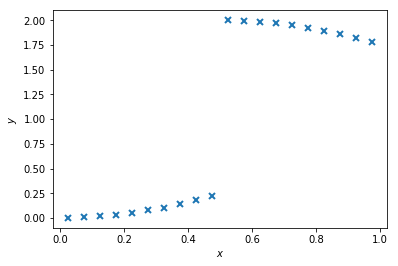

In [3]:
from pyDOE import *
dim = 1
n = 20
noise=0
sigma = eval('lambda x: ' + str(noise))
objective = Ex1Func(sigma=sigma)
X = lhs(dim, n , criterion='center')
Y = np.array([objective(x) for x in X])[:, None]
Xm = np.mean(X)


Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm) / Xv

fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [4]:
#build the model
k = gpflow.kernels.RBF(1)
l = gpflow.likelihoods.Gaussian()
m = gpflow.gpmc.GPMC(Xnorm, Y, k, l)
m

Name,values,prior,constraint
model.V,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
model.kern.lengthscales,[ 1.],None,+ve
model.kern.variance,[ 1.],None,+ve
model.likelihood.variance,[ 1.],None,+ve


In [5]:
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1.,1.)

m.likelihood.variance = 1e-8
m.likelihood.variance.fixed = True

In [6]:
m.optimize(maxiter=5000) # start near MAP

      fun: array([-139.07071053])
 hess_inv: <22x22 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.40000203, -1.20781109,  3.38836279, -2.54581491,  2.10152214,
       -5.72168444,  4.01061758, -2.16391735, -4.2082929 ,  4.77546284,
        0.77414652,  0.94803703,  0.25538526, -2.75424666,  0.50697039,
       -2.91894453,  5.64156708,  1.20111704, -1.75308639, -5.14795993,
       -4.85700449,  0.73497039])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3217
      nit: 2803
   status: 0
  success: True
        x: array([  3.67122895e-04,   1.09211060e+00,   1.17140336e+00,
         9.18811375e-03,   1.26617664e-02,   9.35291438e-01,
         1.03359056e+00,   4.43632472e-02,   7.80202123e-01,
         9.99927850e-01,   2.64932750e-02,   3.99295938e-01,
         2.42077351e-01,   5.01330697e-02,   2.24720566e-01,
         2.17966187e-02,   4.99040875e-01,  -2.92739625e-01,
        -2.70147617e-02,  -9.34252634e-03,  -1.73501803e+00,
         2.8420

In [7]:
samples = m.sample(100, verbose=True, epsilon=0.01, thin = 2, burn = 100, Lmax = 80)

burn-in sampling started


Iteration:  100 	 Acc Rate:  0.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  0.0 %


Iteration:  200 	 Acc Rate:  0.0 %


In [8]:
m

Name,values,prior,constraint
model.V,[[ 3.67122895e-04] [ 1.09211060e+00] [ 1.17140336e+00] [ 9.18811375e-03] [ 1.26617664e-02] [ 9.35291438e-01] [ 1.03359056e+00] [ 4.43632472e-02] [ 7.80202123e-01] [ 9.99927850e-01] [ 2.64932750e-02] [ 3.99295938e-01] [ 2.42077351e-01] [ 5.01330697e-02] [ 2.24720566e-01] [ 2.17966187e-02] [ 4.99040875e-01] [ -2.92739625e-01] [ -2.70147617e-02] [ -9.34252634e-03]],"N([ 0.],[ 1.])",(none)
model.kern.lengthscales,[ 0.1624574],"Ga([ 1.],[ 1.])",+ve
model.kern.variance,[ 2.89868198],"Ga([ 1.],[ 1.])",+ve
model.likelihood.variance,[ 1.00000000e-08],None,[FIXED]


In [9]:
sample_df = m.get_samples_df(samples)
like_var_samples = m.likelihood.variance.get_samples_df(samples)

In [10]:
noise_var = np.array([])
for s in like_var_samples:
    noise_var = np.append(noise_var, s)

In [15]:
xnew = np.linspace(0,1,50)[:,None]
xx = (xnew - Xm)/Xv
meanmat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
varmat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
noisemat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean, v = m.predict_f(xx)
    var = v[:,:]
    meanmat[i,:] = mean[:,0]
    varmat[i,:] = np.diag(var)
    noisemat[i,:] = noise_var[i]

In [16]:
def visualize(Xgrid, Mgrid, Vargrid, noise_var):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Stdgrid = np.sqrt(Vargrid)
    Std_noise = np.sqrt(noise_var)
    
    lower = Mgrid - 2*Stdgrid
    upper = Mgrid + 2*Stdgrid
    
    lower1 = lower - 2*Std_noise
    upper1 = upper + 2*Std_noise
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], lower1, upper1,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

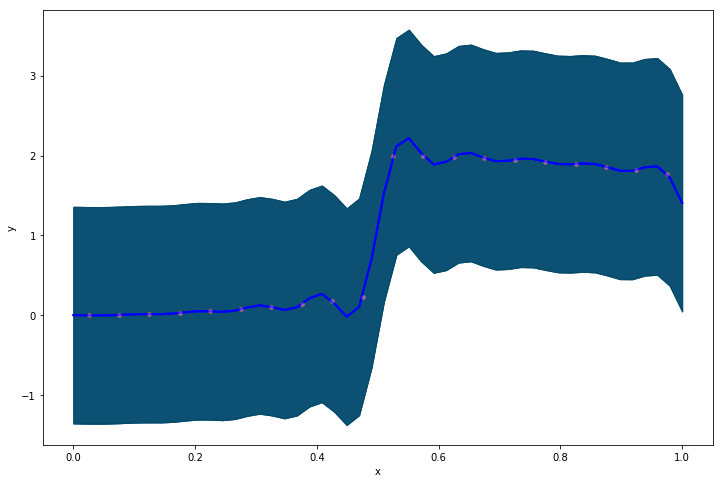

In [17]:
mini = 5
maxi = 10
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, meanmat[i,:], varmat[i,:], noisemat[i,:])